# Understanding bootstrapped confidence intervals, raw data, and p-values

The goal of this tutorial is to explore the relationship between raw data, bootstrapped confidence intervals, and traditional p-values. 

A 95% confidence interval around the mean of a distribution says that there is a 95% chance that the true mean actually lies within that range. Assuming, of course, that your data is representative of the population.

A p-value (e.g. 0.05) describes the chance that two data sets actually come from the same distribution. In other words, given dataset A and B, there are two possibilities:
* H1: they come from different distributions
* H0: they come from the same distribution (null hypothesis)

The p-value tells you what the probability is that you erroneously reject the null hypothesis, thus incorrectly stating that the two datasets represent different distributions. 

These are fundamentally different concepts. The confidence interval is a statistic about a single distribution. The p-value is a statistic comparing two distributions. However, comparing the confidence intervals of two different distributions generally - but not always - can yield similar conclusions to a p-value calculation.

For example, it may seem intuitive to think that if the 95% confidence intervals of two distributions just barely touch, that the p-value (calculated using the proper test) is 0.05. This, however, usually not the case. 

If the 95% confidence intervals overlap, it does mean that there is a >5% chance that the means of the two distributions are "very similar" to one another. They might in fact be the same, but they are more likely just very close. 


In [2]:
# Define bootstrapping functions
import numpy as np
import scipy.stats
import scipy.signal

CI_LO = 0.025
CI_HI = 0.975

def bootstrap_means_from_data(data, mean_function='mean', iterations=1000):
    np.mean_function = np.__getattribute__(mean_function)
    means = []
    for n in range(iterations):
        indices = np.random.randint(0,len(data),len(data))
        means.append(np.mean_function(data[indices]))
    means.sort()
    return np.array(means)

def bootstrap_confidence_intervals_for_means(m, confidence_lo=CI_LO, confidence_hi=CI_HI):
    confidence_intervals = []
    m.sort()
    n = len(m)
    hi_index = np.min([int(confidence_hi*n), n-1])
    lo_index = int(confidence_lo*n)
    conf_interval = [m[lo_index], m[hi_index]]
    return conf_interval

def bootstrap_confidence_intervals_from_data(data, iterations=1000, mean_function='mean', 
                                             confidence_lo=CI_LO, 
                                             confidence_hi=CI_HI):
    
    m = bootstrap_means_from_data(data, mean_function=mean_function)
    conf_interval = bootstrap_confidence_intervals_for_means(m, confidence_lo, confidence_hi)
    return conf_interval

def bootstrap_confidence_intervals_for_difference_between_two_datasets(A, B, 
                                                                       iterations=1000, 
                                                                       mean_function='mean', 
                                                                       confidence_lo=CI_LO, 
                                                                       confidence_hi=CI_HI):
    
    np.mean_function = np.__getattribute__(mean_function)
    differences = []
    Am = bootstrap_means_from_data(A, mean_function=mean_function, iterations=iterations)
    np.random.shuffle(Am)
    Bm = bootstrap_means_from_data(B, mean_function=mean_function, iterations=iterations)
    np.random.shuffle(Bm)
    differences = np.array(Am) - np.array(Bm)      
    differences.sort()
    n = len(differences)
    hi_index = np.min([int(confidence_hi*n), n-1])
    lo_index = int(confidence_lo*n)
    conf_interval = [differences[lo_index], differences[hi_index]]
    return conf_interval

def calculate_pval_from_confidence_interval(CI_diff):
    # How to obtain the P value from a confidence interval: http://www.bmj.com/content/343/bmj.d2304
    SE = (CI_diff[1] - CI_diff[0])/(2.*1.96)
    if SE == 0:
        return 0
    z = np.abs(np.median(CI_diff)) / SE
    P = np.exp(-0.717*z - 0.416*z**2)
    return P

def calc_pval_from_mixture(A, B, iterations=1000):
    mixture = np.hstack((A,B))
    mixture_ci = bootstrap_means_from_data(mixture, iterations=iterations)
    pval_A = np.argmin( np.abs(mixture_ci-np.mean(A) ) ) /float(iterations)
    pval_B = np.argmin( np.abs(mixture_ci-np.mean(B) ) ) /float(iterations)
    return pval_A, pval_B

def get_bootstrapped_histograms_etc(A, B, A_bootstrapped_means=None, B_bootstrapped_means=None, iterations=1000):

    #bins_min = np.min([np.min(B_bootstrapped_means), np.min(A_bootstrapped_means)])
    #bins_max = np.max([np.max(B_bootstrapped_means), np.max(A_bootstrapped_means)])
    #bins = np.arange(bins_min, bins_max, np.mean([np.diff(A_bootstrapped_means), np.diff(B_bootstrapped_means)]))
    
    if A_bootstrapped_means is None:
        A_bootstrapped_means = bootstrap_means_from_data(A, iterations=iterations)
    
    if B_bootstrapped_means is None:
        B_bootstrapped_means = bootstrap_means_from_data(B, iterations=iterations)
    
    A_bins = np.linspace(np.min(A_bootstrapped_means), np.max(A_bootstrapped_means), len(A))
    B_bins = np.linspace(np.min(B_bootstrapped_means), np.max(B_bootstrapped_means), len(B))
    
    A_hist, A_bin_edges = np.histogram(A_bootstrapped_means, bins=A_bins, density=True)
    B_hist, B_bin_edges = np.histogram(B_bootstrapped_means, bins=B_bins, density=True)
    A_bins = A_bin_edges[1:] - (A_bin_edges[1]-A_bin_edges[0])/2.
    B_bins = B_bin_edges[1:] - (B_bin_edges[1]-B_bin_edges[0])/2.

    # filter
    try:
        A_hist = scipy.signal.medfilt(A_hist, int(len(A)/40.)*3)
    except:
        A_hist = scipy.signal.medfilt(A_hist, int(len(A)/40.)*3+1)
    
    try:
        B_hist = scipy.signal.medfilt(B_hist, int(len(B)/40.)*3)
    except:
        B_hist = scipy.signal.medfilt(B_hist, int(len(B)/40.)*3+1)
    # find the intersection of the two confidence level curves - it must lie in between their means
    bins_interp = np.linspace( np.min(np.hstack((A_bins, B_bins))), 
                              np.max(np.hstack((A_bins, B_bins))),
                              iterations)

    A_hist_interp = np.interp(bins_interp, A_bins, A_hist)
    B_hist_interp = np.interp(bins_interp, B_bins, B_hist)
    E = A_hist_interp - B_hist_interp
    idx_A_mean = np.argmax(E)
    idx_B_mean = np.argmin(E)
    roi = [idx_A_mean, idx_B_mean]
    roi.sort()
    
    return A_hist, B_hist, A_bins, B_bins, bins_interp, A_hist_interp, B_hist_interp, E, roi

def get_intersection_of_confidence_intervals_for_two_distributions(A, B, iterations=1000, 
                                                                   A_bootstrapped_means=None,
                                                                   B_bootstrapped_means=None):
    '''
    This function calculates value, and confidence level, where the bootstrapped distributions of the 
    means for A and B intersect. This confidence level is equivalent to 1 minus the pvalue. 
    
    Intersection calculation based on:
    http://kitchingroup.cheme.cmu.edu/blog/2013/07/04/Estimating-where-two-functions-intersect-using-data/
    
    
    '''
    import numpy as np
    import scipy.stats
    import matplotlib.pyplot as plt
    from scipy.optimize import fsolve

    # first get the confidence level curves
    if A_bootstrapped_means is None:
        A_bootstrapped_means = bootstrap_means_from_data(A, iterations=iterations)
    
    if B_bootstrapped_means is None:
        B_bootstrapped_means = bootstrap_means_from_data(B, iterations=iterations)
        
    r = get_bootstrapped_histograms_etc(A, B, A_bootstrapped_means, B_bootstrapped_means)
    A_hist, B_hist, A_bins, B_bins, bins_interp, A_hist_interp, B_hist_interp, E, roi = r
    A_bin_width = np.mean(np.diff(A_bins))
    B_bin_width = np.mean(np.diff(B_bins))
    
    
    r = get_bootstrapped_histograms_etc(A, B, A_bootstrapped_means, B_bootstrapped_means)
    A_hist, B_hist, A_bins, B_bins, bins_interp, A_hist_interp, B_hist_interp, E, roi = r

    idx_intersection = np.argmin( np.abs(E[roi[0]:roi[1]]) ) # need better intersection estimation
    intersection_x_value = bins_interp[roi[0]:roi[1]][idx_intersection]

    A_idx = np.argmin( np.abs(A_bootstrapped_means - intersection_x_value) )
    B_idx = np.argmin( np.abs(B_bootstrapped_means - intersection_x_value) )
    
    L_A = len(A_bootstrapped_means)
    L_B = len(B_bootstrapped_means)
    
    pval_A = (L_A/2. - np.abs(L_A/2. - A_idx))/L_A
    pval_B = (L_B/2. - np.abs(L_B/2. - B_idx))/L_B
    pval = np.mean([pval_A, pval_B])*2

    return intersection_x_value, pval

def get_conf_lo_hi(bootstrapped_means, confidence_level):
    ci_lo = ((100-confidence_level)/100.)/2.
    ci_hi = 1 - ci_lo
    ci_x = np.linspace(0,1,len(bootstrapped_means))
    ci_lo_val = np.interp(ci_lo, ci_x, bootstrapped_means)
    ci_hi_val = np.interp(ci_hi, ci_x, bootstrapped_means)
    return ci_lo_val, ci_hi_val

def get_conf_lo_hi_idx(bootstrapped_means, confidence_level):
    ci_lo = ((100-confidence_level)/100.)/2.
    ci_hi = 1 - ci_lo
    l = len(bootstrapped_means)
    ci_lo_idx = int(ci_lo*l)
    ci_hi_idx = int(ci_hi*l)
    return ci_lo_idx, ci_hi_idx

def get_pval_from_confidence_intersection(ci_p, n=30):
    t_stat = np.linspace(-5,5,100)
    pval = np.array([scipy.stats.t.sf( np.abs(t_)*.707, n)*2 for t_ in t_stat])
    ci_t_stat = t_stat[np.argmin( np.abs(pval-ci_p) )]
    return scipy.stats.t.sf( np.abs(ci_t_stat), n)*2

def get_confidence_level_from_ttest_pval(tpval, n=30):
    t_stat = np.linspace(-5,5,100)
    pval = np.array([scipy.stats.t.sf( np.abs(t_), n)*2 for t_ in t_stat])
    ci_t_stat = t_stat[np.argmin( np.abs(pval-tpval) )]
    return scipy.stats.t.sf( np.abs(ci_t_stat)*.707, n)*2

def permutation_test(A, B, permutations=1000):
    mixture = np.hstack((A,B))
    diffs = []
    for p in range(permutations):
        np.random.shuffle(mixture)
        A_p = mixture[0:len(A)]
        B_p = mixture[len(A):len(A)+len(B)]
        A_m = np.mean(A_p)
        B_m = np.mean(B_p)
        diffs.append(A_m-B_m)
    diffs.sort()
    diffs = np.array(diffs)
    actual_diff = np.mean(A)-np.mean(B)
    idx = np.argmin( np.abs(diffs-actual_diff))
    L = len(diffs)
    pval = (L/2. - np.abs(L/2. - idx))/L*2
    return pval, actual_diff, diffs
        
        
        

In [3]:
# test forward and reverse functions
print get_pval_from_confidence_intersection(0.05)
print get_confidence_level_from_ttest_pval(0.00729)

0.00729333997401
0.0507379598269


# Plotting Functions

In [4]:
def scatter_box(ax, x, data, 
                xwidths=[0.3, 0.2, 0.1], 
                confidence_levels=[50,95,99], 
                ttest_pvals = [0.5, 0.05, 0.01],
                alphas=[0.7, 0.5, 0.3],
                mean_line_width=1, 
                mean_function='mean', 
                iterations=1000, 
                markersize=5,
                color='black',
                markeralpha=1,
                markeredgecolor='none',
                display='histogram'):
    '''
    plot raw data with random x scattering and shaded confidence levels
    
    x                 - x-val where scatter should be centered about
    data              - list or array of the data points
    confidence_levels - list of the confidence levels to shade
    xwidths           - width of shading for the confidence levels
    alphas            - alpha for each confidence level
    mean_line_width   - line width for the mean
    mean_function     - function to use for calculating mean, e.g. 'mean' or 'median'
    iterations        - how many iterations to use for bootstrapping
    markersize        - size of scatter points
    color             - color
    '''  
    
    bootstrapped_means = bootstrap_means_from_data(data, mean_function=mean_function, iterations=iterations)
    
    # shaded confidence intervals
    if display == 'discreet':
        for i, confidence_level in enumerate(confidence_levels):
            ci_lo_val, ci_hi_val = get_conf_lo_hi(bootstrapped_means, confidence_level)
            ax.fill_between([x-xwidths[i],x+xwidths[i]], [ci_lo_val, ci_lo_val], [ci_hi_val, ci_hi_val], 
                            facecolor='white', 
                            edgecolor='none',
                            zorder=-1*confidence_level)
            ax.fill_between([x-xwidths[i],x+xwidths[i]], [ci_lo_val, ci_lo_val], [ci_hi_val, ci_hi_val], 
                            facecolor=color, 
                            edgecolor='none',
                            alpha=alphas[i],
                            zorder=-1*confidence_level)
        np.mean_function = np.__getattribute__(mean_function)
        ax.hlines([np.mean_function(data)], x-xwidths[0], x+xwidths[0], 
                  linewidth=mean_line_width, color=color)
        
    if display == 'histogram':
        bins = np.linspace(np.min(bootstrapped_means), np.max(bootstrapped_means), len(data)/5.)
        hist, be = np.histogram(bootstrapped_means, bins=bins, normed=True)
        hist = scipy.signal.medfilt(hist, int(len(data)/60)*2+1)
        bins = bins[1:] - (bins[1]-bins[0])/2.
        ax.fill_betweenx(bins, hist*xwidths[0]*2+x, -1*(hist)*xwidths[0]*2+x, 
                                facecolor=color, 
                                edgecolor='none',
                                alpha=alphas[0],
                                zorder=-1)

        # mean line
        np.mean_function = np.__getattribute__(mean_function)
        ax.hlines([np.mean_function(data)], x-np.max(hist*xwidths[0]*2), x+np.max(hist*xwidths[0]*2), 
                  linewidth=mean_line_width, color=color)
    
    if display == 't_adjusted_discreet':
        for i, ttest_pval in enumerate(ttest_pvals):
            confidence_level = int((1 - get_confidence_level_from_ttest_pval(ttest_pval))*100)
            ci_lo_val, ci_hi_val = get_conf_lo_hi(bootstrapped_means, confidence_level)
            
            ax.fill_between([x-xwidths[i],x+xwidths[i]], [ci_lo_val, ci_lo_val], [ci_hi_val, ci_hi_val], 
                            facecolor='white', 
                            edgecolor='none',
                            zorder=-1*confidence_level)
            ax.fill_between([x-xwidths[i],x+xwidths[i]], [ci_lo_val, ci_lo_val], [ci_hi_val, ci_hi_val], 
                            facecolor=color, 
                            edgecolor='none',
                            alpha=alphas[i],
                            zorder=-1*confidence_level)
        np.mean_function = np.__getattribute__(mean_function)
        ax.hlines([np.mean_function(data)], x-xwidths[0], x+xwidths[0], 
                  linewidth=mean_line_width, color=color)
    # scattered data
    if 1:
        xvals = [x+np.random.random()*xwidths[0]*2-xwidths[0] for yi in range(len(data))]
        ax.plot(xvals, data, 'o', 
                markerfacecolor=color, 
                markeredgecolor=markeredgecolor,
                markersize=markersize,
                alpha=markeralpha)   

    

In [5]:
def plot_confidence_interval_curves(ax, data, iterations=1000, 
                                    color='black', confidence_level=None, show_hline=False):
    bootstrapped_means = bootstrap_means_from_data(data, iterations=iterations)
    ax.hist(bootstrapped_means, bins=len(data)/2., orientation='horizontal', normed=True, 
            edgecolor='none',
            facecolor=color,
            alpha=0.3)
    '''
    if show_hline:
        ax.hlines([np.mean(bootstrapped_means)],0,1,color=color)
    
    if confidence_level == 'all':
        ax.fill_betweenx(bootstrapped_means, np.zeros_like(ci_levels), ci_levels,
                         facecolor=color, edgecolor='none', alpha=0.5)
    elif confidence_level is not None:
        ci_index_lo, ci_index_hi = get_conf_lo_hi_idx(bootstrapped_means, confidence_level)
        ci_levels_range = ci_levels[ci_index_lo:ci_index_hi]
        ax.fill_betweenx(bootstrapped_means[ci_index_lo:ci_index_hi], 
                         np.zeros_like(ci_levels_range), 
                         ci_levels_range,
                         facecolor=color, edgecolor='none', alpha=0.5)
     '''


# Plot the data

In [6]:
# plot some sample data using different visual representations
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats

# get some random sample data
def get_sample_data(mean, std, num_samples):
    norm = scipy.stats.norm(mean,std)
    return norm.rvs(num_samples)

def run_analysis_on_A_B(A,B):
    # set up figure
    fig = plt.figure(figsize=(15,5))
    #ymax = np.max([np.max(A), np.max(B)])
    #ymin = np.min([np.min(A), np.min(B)])

    ymin = -10
    ymax = 10

    # scatter plot of the data
    ax = fig.add_subplot(161)
    scatter_box(ax, 1, A, mean_function='mean', color='blue', markersize=3, confidence_levels=[], display='none')
    scatter_box(ax, 2, B, mean_function='mean', color='green', markersize=3, confidence_levels=[], display='none')
    #ax.set_ylim(ymin, ymax)
    #ax.set_xticks([])
    ax.set_ylabel('value')

    # plot histograms of the distributions
    ax = fig.add_subplot(162)
    ax.hist(A, alpha=0.5, color='blue', orientation='horizontal')
    ax.hist(B, alpha=0.5, color='green', orientation='horizontal')
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([])
    ax.set_yticks([])

    # plot continuous confidence intervals
    ax = fig.add_subplot(163)
    plot_confidence_interval_curves(ax, A, iterations=1000, color='blue', confidence_level=95)
    plot_confidence_interval_curves(ax, B, iterations=1000, color='green', confidence_level=95)
    intersection, intersection_pval = get_intersection_of_confidence_intervals_for_two_distributions(A, B)
    ax.hlines(intersection, 0, 1, color='red')
    ax.set_ylim(ymin, ymax)
    #ax.set_xticks([])
    #ax.set_yticks([])

    if 0:
        # plot E
        ax = fig.add_subplot(154)
        r = get_bootstrapped_histograms_etc(A, B)
        A_hist, B_hist, A_bins, B_bins, bins_interp, A_hist_interp, B_hist_interp, E, roi = r
        ax.plot(E, bins_interp)
        ax.hlines(intersection, -1, 1, color='red')
        ax.vlines(0, ymin, ymax, color='red')
        ax.set_ylim(ymin, ymax)

    # plot scatter boxes
    ax = fig.add_subplot(164)
    scatter_box(ax, 1, A, mean_function='mean', color='blue', markersize=3, iterations=1000)
    scatter_box(ax, 2, B, mean_function='mean', color='green', markersize=3, iterations=1000)
    ax.hlines(intersection, 0, 3, color='red')
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = fig.add_subplot(165)
    scatter_box(ax, 1, A, mean_function='mean', color='blue', markersize=3, iterations=1000, display='discreet')
    scatter_box(ax, 2, B, mean_function='mean', color='green', markersize=3, iterations=1000, display='discreet')
    ax.hlines(intersection, 0, 3, color='red')
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = fig.add_subplot(166)
    scatter_box(ax, 1, A, mean_function='mean', color='blue', markersize=3, 
                iterations=1000, display='t_adjusted_discreet')
    scatter_box(ax, 2, B, mean_function='mean', color='green', markersize=3, 
                iterations=1000, display='t_adjusted_discreet')
    ax.hlines(intersection, 0, 3, color='red')
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([])
    ax.set_yticks([])




    print 'intersectional: ', intersection_pval
    print 'ttest adjusted intersectional: ', get_pval_from_confidence_intersection(intersection_pval, n=np.mean([len(A), len(B)]))
    print 'ttest: ', scipy.stats.ttest_ind(A,B)[1]
    pvalA, pvalB = calc_pval_from_mixture(A, B, iterations=1000)
    mixture_pval = 1- np.max([pvalA, pvalB]) + np.min([pvalA, pvalB])
    print 'resampling: ', mixture_pval
    print 'intersection: ', intersection
    
    pval, ad, diff = permutation_test(A, B, permutations=1000)
    print 'permutation pval: ', pval


intersectional:  0.208
ttest adjusted intersectional:  0.0847428956055
ttest:  0.0826540055823
resampling:  0.081
intersection:  1.05657823314
permutation pval:  0.074


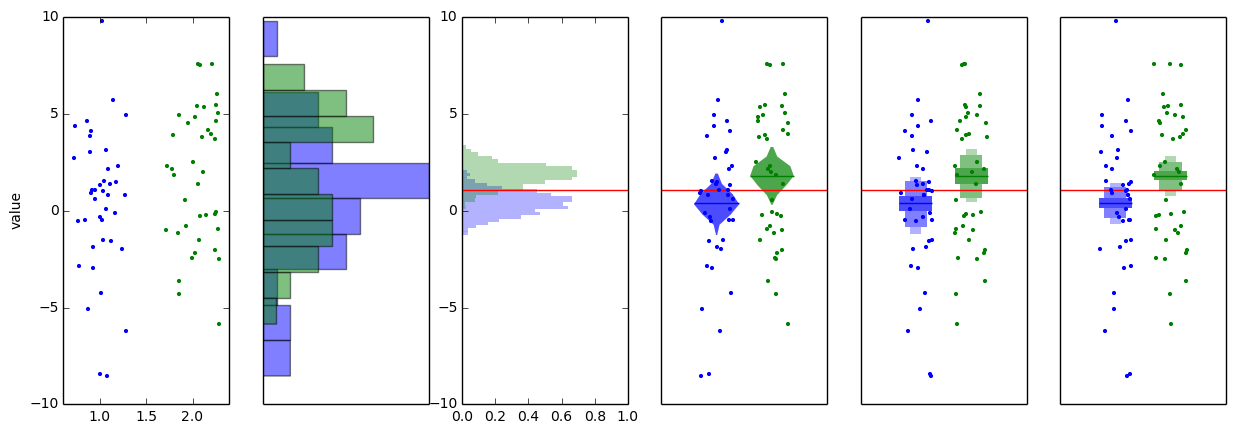

In [7]:
A = get_sample_data(0,4,40)
B = get_sample_data(2,4,40)
run_analysis_on_A_B(A,B)

intersectional:  0.284
ttest adjusted intersectional:  0.11928859881
ttest:  0.550589177988
resampling:  0.468
intersection:  1.64304960225
permutation pval:  0.48


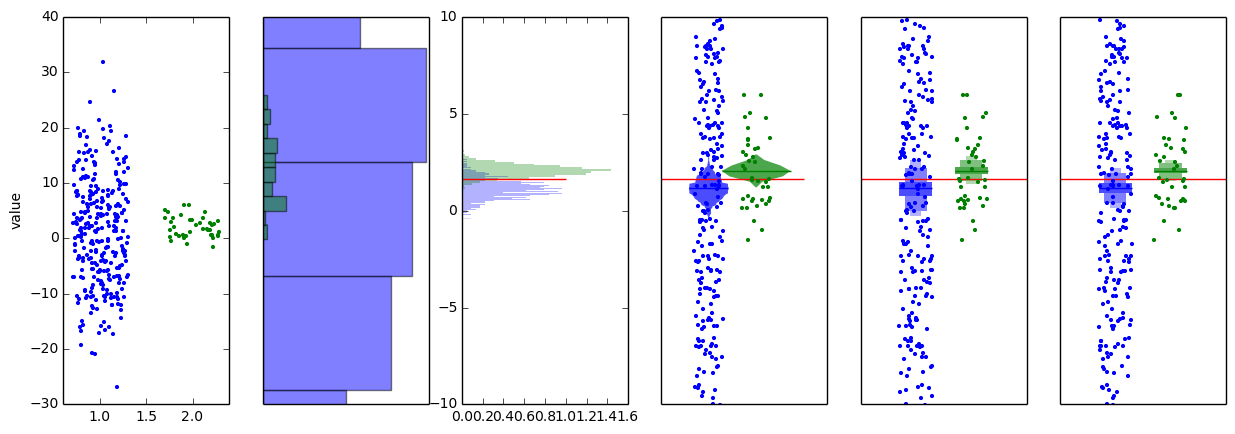

In [8]:
A = get_sample_data(0,10,300)
B = get_sample_data(2,2,40)
run_analysis_on_A_B(A,B)

intersectional:  0.164
ttest adjusted intersectional:  0.0497928457376
ttest:  0.0466291804177
resampling:  0.041
intersection:  1.31372451166
permutation pval:  0.044


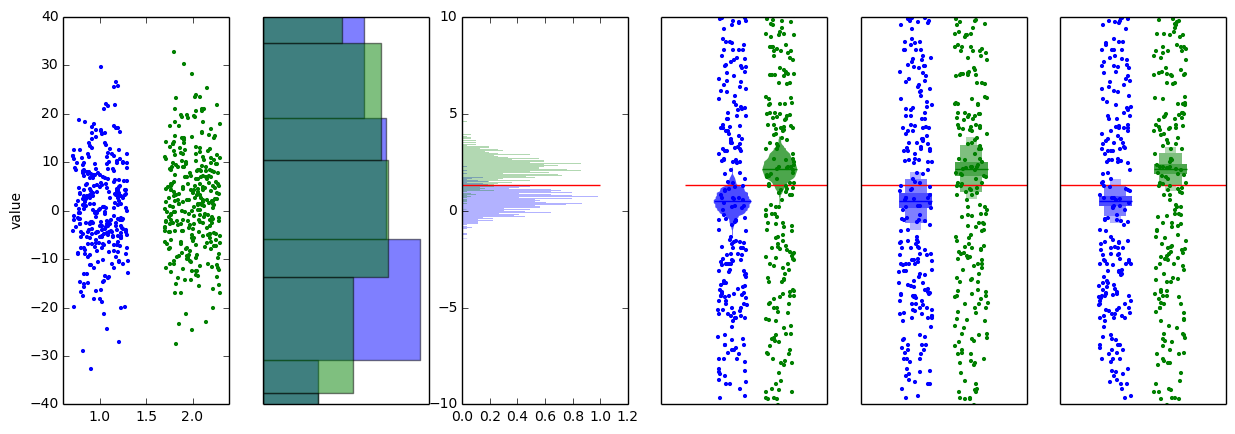

In [9]:
A = get_sample_data(0,10,300)
B = get_sample_data(2,10,300)
run_analysis_on_A_B(A,B)

intersectional:  0.033
ttest adjusted intersectional:  0.00300109277395
ttest:  0.000144302915924
resampling:  0.001
intersection:  0.0922303142083


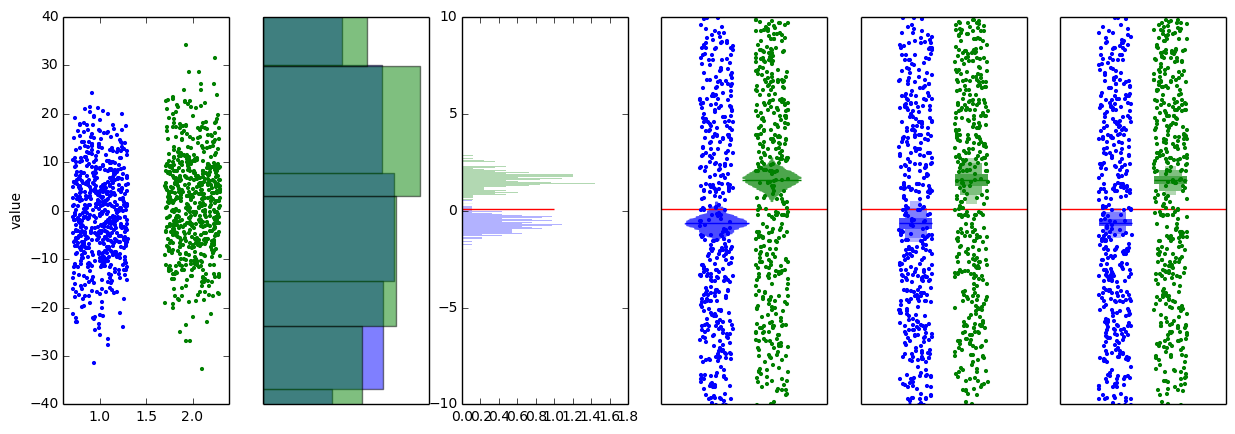

In [1310]:
A = get_sample_data(0,10,600)
B = get_sample_data(2,10,600)
run_analysis_on_A_B(A,B)

intersectional:  0.003
ttest adjusted intersectional:  5.79671740332e-05
ttest:  3.49334195356e-05
resampling:  0.001
intersection:  1.04269638107


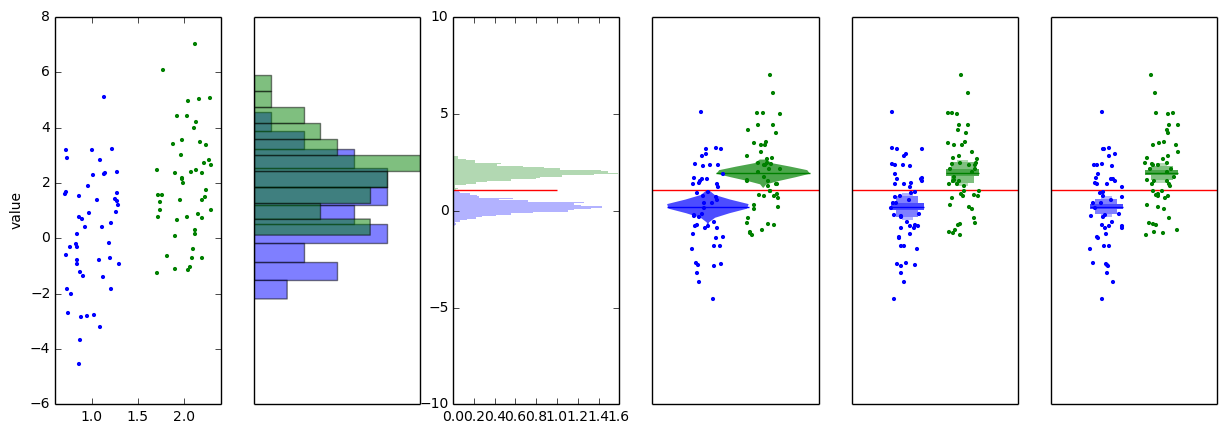

In [1314]:
A = get_sample_data(0,2,50)
B = get_sample_data(1.5,2,50)
run_analysis_on_A_B(A,B)

#### 1: Scatter plot of raw data

#### 2: Histogram of the data

#### 3: Histograms of bootstrapped means of the distributions
Red line indicates the value at which the two histograms intersect. The value of the histograms at this location indicates the confidence level at which the distributions are equal. This is similar to--but not equal to--the p-value aquired from a t-test

#### 4: Scatter plot of raw data with shaded blobs representing the histograms from (3)

#### 5: Same as 4, but discritized to show the 50%, 95%, 99% confidence intervals

#### 6: Similar to (5), but rather than showing the confidence intervals, the shading shows p-value levels
For example, the middle step is for an alpha=0.05. So, if the shaded regions overlap at this level, the p-value is greater than 0.05. If they do not intersect at this level, the p-value is less than 0.05. 

#### Misc Notes
Plotted approach is much better at handling distributions not covered by the t-test: e.g. different sample sizes and different variances. Or is it too lenient?

# Statistics

In [10]:
# compare different methods for calculating p-values
def calculate_pvalues_with_different_methods(A, B):
    # calculate pval from intersection of A and B confidence intervals
    intersection, intersection_pval = get_intersection_of_confidence_intervals_for_two_distributions(A, B)
    # calculate pval from confidence interval around the difference of the means of A and B
    diff = bootstrap_confidence_intervals_for_difference_between_two_datasets(A, B)
    backcalc_pval = calculate_pval_from_confidence_interval(diff)
    # calculate pval from location of A / B means relative to the null distribution
    pvalA, pvalB = calc_pval_from_mixture(A, B, iterations=1000)
    mixture_pval = 1- np.max([pvalA, pvalB]) + np.min([pvalA, pvalB]) 
    # calculate pval from t test
    t, pval = scipy.stats.ttest_ind(A,B)
    #t, pval = scipy.stats.mannwhitneyu(A,B)
    permutation_pval, ad, diff = permutation_test(A, B, permutations=1000)
    return intersection_pval, backcalc_pval, permutation_pval, pval, t

intersection_pval, backcalc_pval, mixture_pval, pval, t = calculate_pvalues_with_different_methods(A, B)
print 'Intersection pval: ', intersection_pval
print 'Adjusted intersection pval: ', (intersection_pval + intersection_pval**2)/2.
print 'Difference backcalculated pval: ', backcalc_pval
print 'Resampling mixture pval: ', mixture_pval
print 'T test pval: ', pval

Intersection pval:  0.157
Adjusted intersection pval:  0.0908245
Difference backcalculated pval:  0.0544792955513
Resampling mixture pval:  0.062
T test pval:  0.0466291804177


In [13]:
def test_correct(test, mA, mB, stdA, stdB, nA, nB, pval=0.05):
    if mA == mB:
        equal = True
    else:
        equal = False

    A = get_sample_data(mA,stdA,nA)
    B = get_sample_data(mB,stdB,nB)
        
    if test == 'intersection':
        intersection, test_pval = get_intersection_of_confidence_intervals_for_two_distributions(A, B)
    elif test == 'ttest':
        t, test_pval = scipy.stats.ttest_ind(A, B)
    elif test == 'resampling':
        pvalA, pvalB = calc_pval_from_mixture(A, B, iterations=1000)
        test_pval = 1- np.max([pvalA, pvalB]) + np.min([pvalA, pvalB]) 
        
    if equal:
        if test_pval < pval:
            return 1 # false positive
        else:
            return 0
    else:
        if test_pval < pval:
            return 0
        else:
            return -1 # false negative
    
Am, Bm, Astd, Bstd, An, Bn = 0, 7, 20, 20, 300, 30
    
a = np.array([test_correct('intersection', Am, Bm, Astd, Bstd, An, Bn, pval=0.05) for i in range(100)])
print 'intersection:'
print 'False positive: ', len(np.where(a==1)[0])/float(len(a))
print 'False negative: ', len(np.where(a==-1)[0])/float(len(a))

a = np.array([test_correct('ttest', Am, Bm, Astd, Bstd, An, Bn, pval=0.05) for i in range(100)])
print 'ttest:'
print 'False positive: ', len(np.where(a==1)[0])/float(len(a))
print 'False negative: ', len(np.where(a==-1)[0])/float(len(a))

a = np.array([test_correct('resampling', Am, Bm, Astd, Bstd, An, Bn, pval=0.05) for i in range(100)])
print 'resampling:'
print 'False positive: ', len(np.where(a==1)[0])/float(len(a))
print 'False negative: ', len(np.where(a==-1)[0])/float(len(a))

intersection:
False positive:  0.0
False negative:  0.62
ttest:
False positive:  0.0
False negative:  0.6
resampling:
False positive:  0.0
False negative:  1.0


### Statistics - iterate through many random samples to show correlations of different pval approaches

In [12]:
# iterate through many random samples to see correlations among p-value measurements
intersection_pval_arr, backcalc_pval_arr, mixture_pval_arr, pval_arr, t_arr, variance_ratio = [], [], [], [], [], []
for i in range(5000):
    sample_size = np.random.randint(20,50)
    std = 3
    A = get_sample_data(np.random.randint(-10,10),std, sample_size)
    sample_size = np.random.randint(20,50)
    std = np.random.randint(1,15)
    #std *= 5
    B = get_sample_data(np.random.randint(-10,10),std, sample_size)
    intersection_pval, backcalc_pval, mixture_pval, pval, t = calculate_pvalues_with_different_methods(A, B)
    
    v = [np.var(A), np.var(B)]
    v.sort()
    v_ratio = v[-1] / v[0]
    
    intersection_pval_arr.append(intersection_pval)
    backcalc_pval_arr.append(backcalc_pval)
    mixture_pval_arr.append(mixture_pval)
    pval_arr.append(pval)
    t_arr.append(t)
    variance_ratio.append(v_ratio)

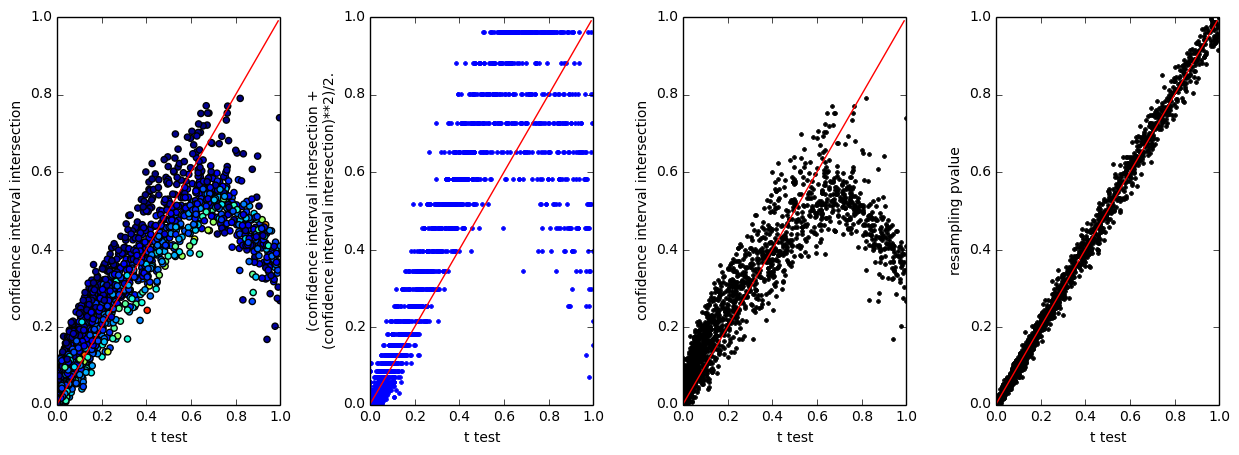

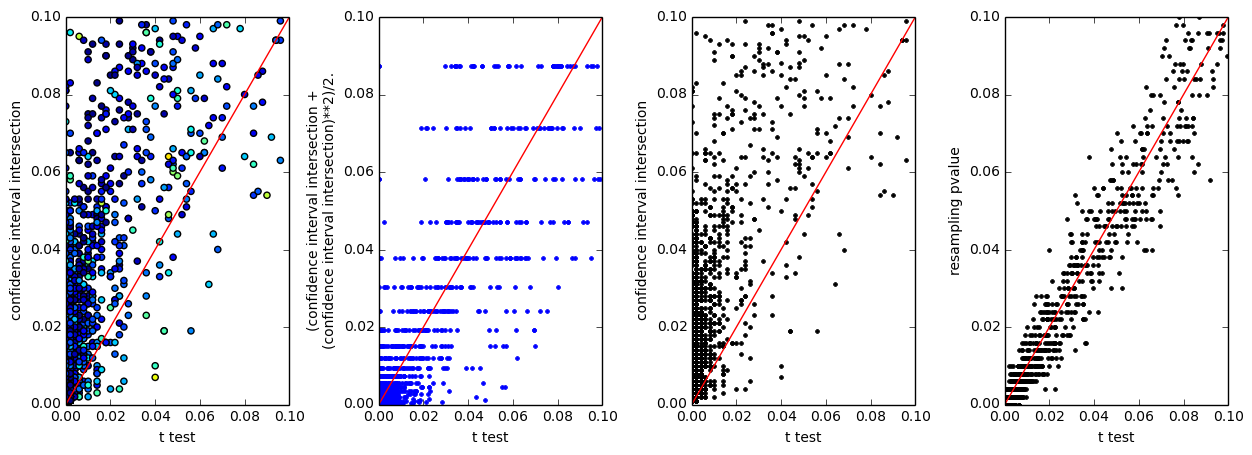

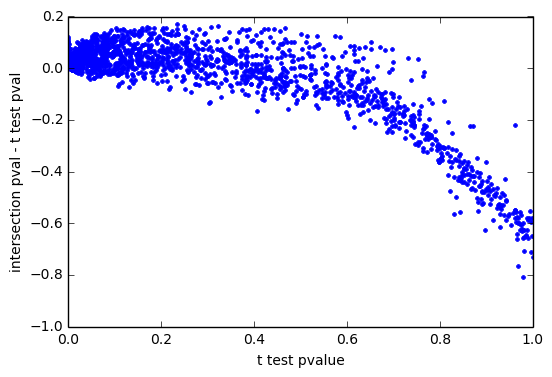

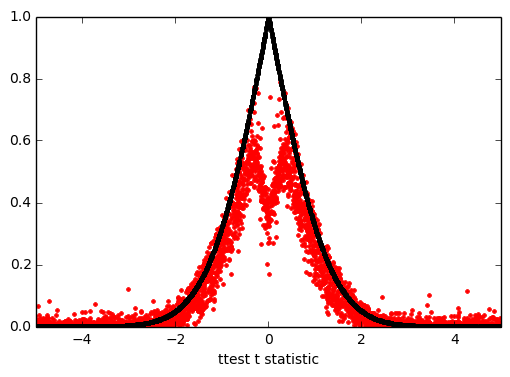

In [14]:
# plot results from the iterations
def plot_statistics_results(intersection_pval_arr, backcalc_pval_arr, mixture_pval_arr, pval_arr, variance_ratio, xylim=1):
    fig = plt.figure(figsize=(15,5))
    fig.subplots_adjust(wspace=0.4)
    x = np.arange(0,1,0.01)

    ax = fig.add_subplot(141)
    ax.scatter(mixture_pval_arr, np.array(intersection_pval_arr), c=np.array(variance_ratio))
    ax.plot(x,x,color='red')
    ax.set_xlabel('t test')
    ax.set_ylabel('confidence interval intersection')
    ax.set_xlim(0,xylim)
    ax.set_ylim(0,xylim)

    ax = fig.add_subplot(142)
    #ax.plot(scipy.stats.t.sf( np.abs(np.array(t_arr))*0.77, 25)*2, np.array(intersection_pval_arr), '.', color='black')
    corrected_intersection_pval_arr = np.array(intersection_pval_arr)*np.array(variance_ratio)**0.25
    corrected_ci_pval = [get_pval_from_confidence_intersection(ci_p, n=30) for ci_p in corrected_intersection_pval_arr]
    ax.plot(pval_arr, corrected_ci_pval, '.')
    ax.plot(x,x,color='red')
    ax.set_xlabel('t test')
    ax.set_ylabel('(confidence interval intersection + \n(confidence interval intersection)**2)/2.')
    ax.set_xlim(0,xylim)
    ax.set_ylim(0,xylim)
        
    ax = fig.add_subplot(143)
    ax.plot(mixture_pval_arr, np.array(intersection_pval_arr), '.', color='black')
    ax.plot(x,x,color='red')
    ax.set_xlabel('t test')
    ax.set_ylabel('confidence interval intersection')
    ax.set_xlim(0,xylim)
    ax.set_ylim(0,xylim)
    
    ax = fig.add_subplot(144)
    ax.plot(pval_arr, mixture_pval_arr, '.', color='black')
    ax.plot(x,x,color='red')
    ax.set_xlabel('t test')
    ax.set_ylabel('resampling pvalue')
    ax.set_xlim(0,xylim)
    ax.set_ylim(0,xylim)

    
plot_statistics_results(intersection_pval_arr, backcalc_pval_arr, mixture_pval_arr, pval_arr, variance_ratio, xylim=1)
plot_statistics_results(intersection_pval_arr, backcalc_pval_arr, mixture_pval_arr, pval_arr, variance_ratio, xylim=0.1)

fig = plt.figure()
ax = fig.add_subplot(111)
y = np.array(intersection_pval_arr) - pval_arr
ax.plot(pval_arr, y, '.')
ax.set_xlabel('t test pvalue')
ax.set_ylabel('intersection pval - t test pval')


fig = plt.figure()
fig.subplots_adjust(wspace=0.4)


ax = fig.add_subplot(111)
ax.plot(np.array(t_arr)*.78, np.array(intersection_pval_arr), '.', color='red')
ax.plot(t_arr, pval_arr, '.', color='black')
ax.set_xlim(-5,5)
ax.set_xlabel('ttest t statistic')



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter?

# Multiple Comparisons

Bonferoni correction - to deal with multiple comparisons, simple use a larger confidence interval.
e.g. if for a comparison between two distributions you like alpha=0.05, use a confidence interval of 95%
For n comparisons, use a confidence level of (1 - alpha / (n-1) )*100%
https://en.wikipedia.org/wiki/Bonferroni_correction



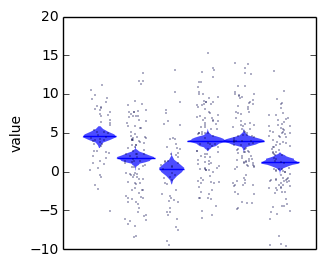

In [580]:
# get some random sample data
def get_sample_data(mean, std, num_samples):
    norm = scipy.stats.norm(mean,std)
    return norm.rvs(num_samples)
A = get_sample_data(1,5,100)
B = get_sample_data(1,5,100)
C = get_sample_data(1,5,50)
D = get_sample_data(4,5,100)
E = get_sample_data(4,5,100)
F = get_sample_data(4,5,50)
distributions = [A, B, C, D, E, F]
np.random.shuffle(distributions)

# set up figure
fig = plt.figure(figsize=(15,3))

# scatter plot of the data
ax = fig.add_subplot(141)
for i, d in enumerate(distributions):
    scatter_box(ax, i, d, mean_function='mean', color='blue', markersize=1, markeralpha=0.3)
ax.set_ylim(-10,20)
ax.set_xticks([])
ax.set_ylabel('value')

In [132]:
# calculate adjacency matrix according to confidence interval pvalues
def get_groups(data_list):
    #bootstrapped = [bootstrap_means_from_data(d, mean_function='mean', iterations=1000) for d in data_list]
    # should only calculate bootstrapped means once!
    pval_mat = np.ones([len(data_list),len(data_list)])
    bootstrapped_means = []
    for d in data_list:
        bootstrapped_means.append(bootstrap_means_from_data(d, mean_function='mean', iterations=1000))
    for i in range(len(data_list)):
        for j in range(len(data_list)):
            A = data_list[i]
            B = data_list[j]
            if i==j:
                intersection_pval = 1
            elif i > j: # symmetric
                intersection_pval = pval_mat[j,i]
            else:
                intersection, intersection_pval = get_intersection_of_confidence_intervals_for_two_distributions(
                                                  A, B,
                                                  A_bootstrapped_means=bootstrapped_means[i],
                                                  B_bootstrapped_means=bootstrapped_means[j])
            pval_mat[i,j] = intersection_pval
    return pval_mat

In [133]:
# organize the results accound to louvain communities
import networkx # sudo apt-get install python-networkx
import community # https://bitbucket.org/taynaud/python-louvain
def calculate_louvain_communities(assignment_matrix, node_order=None):
    # Calculate louvain communities
    G = networkx.to_networkx_graph(assignment_matrix, create_using=networkx.Graph())  
    louvain_community_dict = community.best_partition(G)
    # Convert community assignmet dict into list of communities
    louvain_comms = {}
    for node_index, comm_id in louvain_community_dict.iteritems():
        if comm_id in louvain_comms.keys():
            louvain_comms[comm_id].append(node_index)
        else:
            louvain_comms.setdefault(comm_id, [node_index])
    nodes_louvain_ordered = [node for comm in louvain_comms.values() for node in comm]
    # reorder original matrix according to node order
    adjacency_matrix = np.zeros_like(assignment_matrix)
    for i in range(assignment_matrix.shape[0]):
        for j in range(assignment_matrix.shape[0]):
            r = nodes_louvain_ordered.index(i)
            c = nodes_louvain_ordered.index(j)
            adjacency_matrix[r,c] = assignment_matrix[i,j] 
    return louvain_community_dict, nodes_louvain_ordered, adjacency_matrix


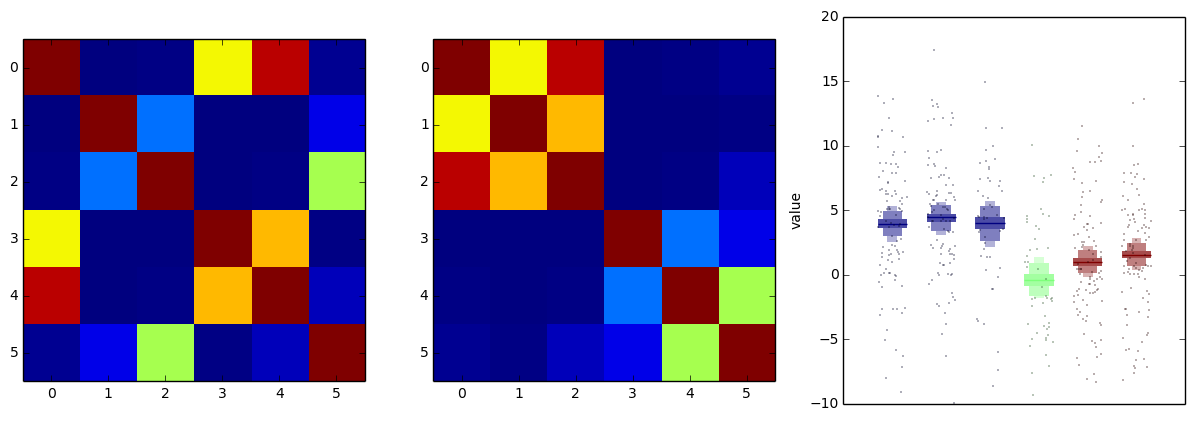

In [134]:
# re-plot the scatter box, sorted and colored according to louvain groups
pval_mat = get_groups(distributions)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.imshow(pval_mat, interpolation='nearest')

#  now group data by louvain communities
louvain_community_dict, nodes_louvain_ordered, adjacency_matrix = calculate_louvain_communities(pval_mat)

ax = fig.add_subplot(132)
ax.imshow(adjacency_matrix, interpolation='nearest')

# scatter plot of the data with louvain colors and organization
ax = fig.add_subplot(133)
cmap = plt.get_cmap('jet')
x = 0
for i in nodes_louvain_ordered:
    d = distributions[i]
    color = cmap(louvain_community_dict[i]/float(np.max(louvain_community_dict.values())))
    scatter_box(ax, x, d, mean_function='mean', color=color, markersize=1, markeralpha=0.3)
    x += 1
ax.set_ylim(-10,20)
ax.set_xticks([])
ax.set_ylabel('value')

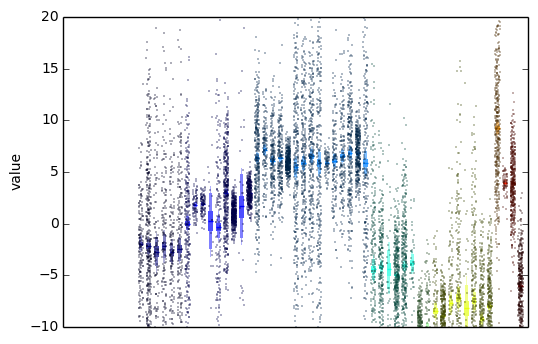

In [136]:
# now try for lots of data sets
distributions = [get_sample_data(np.random.randint(-10,10),np.random.randint(1,10),np.random.randint(20,500)) for i in range(50)]
pval_mat = get_groups(distributions)
louvain_community_dict, nodes_louvain_ordered, adjacency_matrix = calculate_louvain_communities(pval_mat)

fig = plt.figure()
# scatter plot of the data with louvain colors and organization
ax = fig.add_subplot(111)
cmap = plt.get_cmap('jet')
x = 0
for i in nodes_louvain_ordered:
    d = distributions[i]
    color = cmap(louvain_community_dict[i]/float(np.max(louvain_community_dict.values())))
    scatter_box(ax, x, d, mean_function='mean', color=color, markersize=1, markeralpha=0.3)
    x += 1
ax.set_ylim(-10,20)
ax.set_xticks([])
ax.set_ylabel('value')